In [1]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader 
import matplotlib.pyplot as plt
import numpy as np

#加载数据集并且对数据进行预处理

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
BATCH_SIZE = 64
# 加载数据集
trainset = datasets.CIFAR10(root='./data',train=True,download=True,transform=transform)
testset = datasets.CIFAR10(root='./data',train=False,download=True,transform=transform)
# 并把数据集放入数据加载器中 这样就可以进行 batch 处理数据了
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=True)
testloader = DataLoader(testset,batch_size=BATCH_SIZE,shuffle=False)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
# 类别标签
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

In [5]:
#搭建cnn
import torch
import torch.nn.functional as F
import torch.nn as nn
Lr = 5e-3

class Net_1(nn.Module):
    def __init__(self):
        super(Net_1,self).__init__()
        #将卷积和池化层和BacthNormal组合为一个网络层
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,16,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
        )
        # 图像的尺寸缩小半,卷积核的个数翻倍，提取更多的特征
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2,2)
        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(32,64,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
        )
        
        self.conv4 = nn.Sequential(
            nn.Conv2d(64,128,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2,2)
        )
        
        self.conv5 = nn.Sequential(
            nn.Conv2d(128,256,3,padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2,2)
        )
        
        self.gap = nn.AvgPool2d(4,4)    #padding=0
        self.fc1 = nn.Linear(256,10)
        
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = self.gap(x)
        x = x.view(x.size(0),-1)
        x = F.softmax(self.fc1(x),dim=1)
        return x 

In [6]:
net_1 = Net_1()
net_1.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net_1.parameters(),lr=Lr,weight_decay=0)  # L2正则

In [7]:
net_1

Net_1(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


In [8]:
def train(model, criterion, optimizer, trainloader, epochs=5, log_interval=50):
    print('----- Train Start -----')
    train_acc = []
    train_loss = []
    for epoch in range(epochs):
        #样本总数
        total = 0
        #识别正确的个数
        correct = 0
        running_loss = 0.0
        for step, (batch_x, batch_y) in enumerate(trainloader):
            batch_x, batch_y = batch_x.cuda(), batch_y.cuda()
            output = model(batch_x)
#             print('output',output,output.shape)
            optimizer.zero_grad()
            loss = criterion(output, batch_y)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            _,pred_label = torch.max(output.data,1) #取概率最大的数的index作为Label
            correct += (pred_label == batch_y).sum().item() # 只有与label相等的 为1
            total += batch_y.size(0)
            if  step % log_interval == (log_interval-1):
                # 50为一个mini-batches
                # 已经训练的样本数
                #acc
                # mini-batches 打印一下train_acc
                acc = 100*(correct/total)
                ste_loss = running_loss / log_interval
                # 记录训练准确率以输出变化曲线
                train_acc.append(acc)
                train_loss.append(ste_loss)
                print('[%d, %5d,] loss: %.5f acc: %.5f'%
                      (epoch + 1, step+1, ste_loss,acc))
                running_loss = 0.0
    print('----- Train Finished -----')
    return train_acc,train_loss

In [9]:
train_acc ,train_loss= train(net_1, criterion, optimizer, trainloader, epochs=40, log_interval=50)

----- Train Start -----
[1,    50,] loss: 2.21226 acc: 23.78125
[1,   100,] loss: 2.14283 acc: 27.37500
[1,   150,] loss: 2.10464 acc: 29.97917
[1,   200,] loss: 2.09125 acc: 31.57031
[1,   250,] loss: 2.05144 acc: 33.38750
[1,   300,] loss: 2.04304 acc: 34.70312
[1,   350,] loss: 2.01896 acc: 35.97321
[1,   400,] loss: 2.00149 acc: 37.21094
[1,   450,] loss: 1.99056 acc: 38.23958
[1,   500,] loss: 1.98585 acc: 39.08125
[1,   550,] loss: 1.96755 acc: 39.98295
[1,   600,] loss: 1.94410 acc: 40.95052
[1,   650,] loss: 1.97854 acc: 41.46154
[1,   700,] loss: 1.93936 acc: 42.22098
[1,   750,] loss: 1.93544 acc: 42.87292
[2,    50,] loss: 1.91991 acc: 53.87500
[2,   100,] loss: 1.87996 acc: 55.82812
[2,   150,] loss: 1.92297 acc: 55.09375
[2,   200,] loss: 1.87647 acc: 55.89063
[2,   250,] loss: 1.88184 acc: 56.25000
[2,   300,] loss: 1.87785 acc: 56.50521
[2,   350,] loss: 1.85806 acc: 57.03125
[2,   400,] loss: 1.85463 acc: 57.43359
[2,   450,] loss: 1.87333 acc: 57.56944
[2,   500,] loss

[14,   450,] loss: 1.61452 acc: 83.74653
[14,   500,] loss: 1.62145 acc: 83.75938
[14,   550,] loss: 1.63397 acc: 83.64205
[14,   600,] loss: 1.63595 acc: 83.55729
[14,   650,] loss: 1.62445 acc: 83.56731
[14,   700,] loss: 1.63028 acc: 83.55357
[14,   750,] loss: 1.62037 acc: 83.57917
[15,    50,] loss: 1.60293 acc: 85.75000
[15,   100,] loss: 1.61781 acc: 85.00000
[15,   150,] loss: 1.61057 acc: 84.96875
[15,   200,] loss: 1.61402 acc: 84.92969
[15,   250,] loss: 1.60929 acc: 84.95625
[15,   300,] loss: 1.61771 acc: 84.85417
[15,   350,] loss: 1.60604 acc: 84.95089
[15,   400,] loss: 1.62161 acc: 84.83203
[15,   450,] loss: 1.62482 acc: 84.68750
[15,   500,] loss: 1.63098 acc: 84.51875
[15,   550,] loss: 1.62244 acc: 84.43750
[15,   600,] loss: 1.61492 acc: 84.44010
[15,   650,] loss: 1.62196 acc: 84.38942
[15,   700,] loss: 1.61591 acc: 84.39286
[15,   750,] loss: 1.63009 acc: 84.29167
[16,    50,] loss: 1.60836 acc: 85.09375
[16,   100,] loss: 1.60579 acc: 85.32812
[16,   150,] los

[27,   700,] loss: 1.57156 acc: 89.35491
[27,   750,] loss: 1.57467 acc: 89.30000
[28,    50,] loss: 1.57123 acc: 89.03125
[28,   100,] loss: 1.56557 acc: 89.26562
[28,   150,] loss: 1.57136 acc: 89.18750
[28,   200,] loss: 1.56460 acc: 89.30469
[28,   250,] loss: 1.56518 acc: 89.36250
[28,   300,] loss: 1.56751 acc: 89.33333
[28,   350,] loss: 1.57841 acc: 89.17857
[28,   400,] loss: 1.56490 acc: 89.23438
[28,   450,] loss: 1.55798 acc: 89.32639
[28,   500,] loss: 1.56732 acc: 89.32812
[28,   550,] loss: 1.57262 acc: 89.28693
[28,   600,] loss: 1.56585 acc: 89.30729
[28,   650,] loss: 1.56763 acc: 89.29808
[28,   700,] loss: 1.57961 acc: 89.20759
[28,   750,] loss: 1.56770 acc: 89.22500
[29,    50,] loss: 1.56350 acc: 90.00000
[29,   100,] loss: 1.55458 acc: 90.31250
[29,   150,] loss: 1.56401 acc: 90.11458
[29,   200,] loss: 1.56039 acc: 90.05469
[29,   250,] loss: 1.57253 acc: 89.78125
[29,   300,] loss: 1.56480 acc: 89.74479
[29,   350,] loss: 1.57142 acc: 89.63839
[29,   400,] los

In [14]:
def test(model, testloader):
    print('------ Test Start -----')

    correct = 0
    total = 0
    acc_test=[]
    loss_test=[]
    with torch.no_grad():
        for test_x, test_y in testloader:
            images, labels = test_x.cuda(), test_y.cuda()
            output = model(images)
            loss = criterion(output, labels)
            _, predicted = torch.max(output.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()    
            accuracy = 100 * correct / total
            # 一次迭代的acc_test
            acc_test.append(accuracy)
            loss_test.append(loss)
    accuracy = 100 * correct / total
    print('Accuracy of the network is: %.2f %%' % accuracy)
    return acc_test,loss_test

In [15]:
acc_test,loss_test = test(net_1, testloader)

------ Test Start -----
Accuracy of the network is: 80.18 %


In [26]:
import matplotlib.pyplot as plt

def show_acc_curv(acc_test,loss_test,acc_train,loss_train):
    #train_acc
    train_loss_x = list(range(len(loss_train)))
    train_loss_y = loss_train
    train_acc_x = list(range(len(acc_train)))
    train_acc_y = acc_train
    
    # 测试集
    # 每一个epoch个 train 对应一个test
    test_loss_x = train_loss_x[::4]
    test_loss_y = loss_test[:len(test_loss_x)]
    test_acc_x = train_acc_x[::4]
    test_acc_y = acc_test[:len(test_acc_x)]
    
    plt.title('CIFAR10 train test loss and acc')
    
    plt.plot(train_loss_x, train_loss_y, color='green', label='training loss')
    plt.plot(train_acc_x, train_acc_y, color='red', label='training accuracy')
    plt.plot(test_loss_x, test_loss_y, color='Blue', label='testing loss')
    plt.plot(test_acc_x, test_acc_y, color='Yellow', label='testing accuracy')
    
    # 显示图例
    plt.legend()
    plt.xlabel('iterations')
    plt.ylabel('value')

    plt.show()

600
150
150


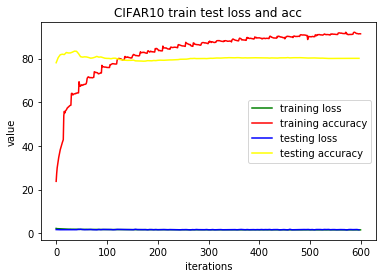

In [27]:
show_acc_curv(acc_test,loss_test,train_acc ,train_loss)